In [3]:
#to check if both points to the same:
#!which python
#sys.executable

# Predicting Impact of 10-K Report 


# Scrap SEC and Upload in MongoDB

### Load Company List 

In [3]:
crs = open("companylist.txt", "r")
companies_dict = {}
for raw in crs:
    companies_dict[raw.strip().split()[0]] = raw.strip().split()[1]

### Build Scrapper 

In [4]:
#le resultat qu'on veut c'est une collection 10-K avec {company:AAPL, date:2015, 10-K:super Iphone mais Ipod en baisse}
#Shema de la base: base: SEC_Data, 10-K et 5-K sont des collections, chaque doc contient date, company, report 

#working for Apple, Micorosft, Google, Amazone, facebook, Berkshire, United Heatlh, Intel, Home Depot, 
#Not working for Ebay, IBM (not present), JP (split in different pages), Johnson (le premier c Item et en dessous les nombres
#Not Exon (reference to other part), BAML (trois Itm7.), Wells Fargo  (un seul), Visa (le premier  c Item 7), 
#Not Chevron Pfizer: (reference), AT&T (reference), Verizon Reference
import os 
import sys
import re
from pymongo import MongoClient
import requests
from bs4 import BeautifulSoup

class SecCrawler():

    def __init__(self, company, limit_year):
        client = MongoClient('localhost', 27017)
        self.company = company
        self.db = client['SEC_Datas_2']
        self.collection = self.db[company]
        self.correspondance = companies_dict
        self.limit = limit_year
                    
    def get_year_all_doc(self, max_date, count, company):
        '''Return the presentation page where all the document for this year are posted. Among them is the 10-K'''
        count=100
        cik = self.correspondance[company]
        base_url = "http://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK="+str(cik)+"&type=10-K&dateb="+str(max_date)+"&owner=exclude&output=xml&count="+str(count)+'&output=xml'
        print(base_url)
        r = requests.get(base_url)
        data = r.text
        soup = BeautifulSoup(data,"html5lib")
        link_list=[] 
        
        for link in soup.find_all('filinghref'):
            URL = link.string
            link_list.append(URL) 
        self.link_list = link_list
        
    def save_in_mongoDB(self):
        for year_links in self.link_list:
            date, K_10_link = get_K_10_link(year_links)
            print(K_10_link)
            print(date)
            if int(date[0:4]) < self.limit:
                print('DATE IS ' + date + "we STOP")
                break
                
            r=requests.get(K_10_link)
            data = r.text
            soup = BeautifulSoup(data,"html5lib")
            
            text = soup.getText(strip=True)
            self.collection.insert_one({'date':date, '10_K':text})

    
def get_K_10_link(documents_link):
    '''The 10-K report is always the first item of the first table'''
    r = requests.get(documents_link)
    data = r.text
    soup = BeautifulSoup(data,"html5lib")
    date = soup.findAll('div',{'class':'info'})[0].text
    tables = soup.findAll('table')
    table = tables[0]
    K_10_link = 'http://www.sec.gov/'+table.find('tr').nextSibling.nextSibling.find('td').nextSibling.nextSibling.nextSibling.nextSibling.find('a')['href']
    return date, K_10_link

company = 'WDN'
SecCrawler_object = SecCrawler(company, 2015)
SecCrawler_object.get_year_all_doc(2018, 1000, company)
#get_K_10_link('https://www.sec.gov/Archives/edgar/data/1065088/000106508818000009/0001065088-18-000009-index.htm')

http://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0001168332&type=10-K&dateb=2018&owner=exclude&output=xml&count=100&output=xml


### Apply Scrapper 

In [22]:
for company in companies_dict.keys():#companies_dict.keys():
    SecCrawler_object = SecCrawler(company, 2015)
    SecCrawler_object.get_year_all_doc(2018, 1000, company)
    SecCrawler_object.save_in_mongoDB()

http://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000320193&type=10-K&dateb=2018&owner=exclude&output=xml&count=100&output=xml


KeyboardInterrupt: 

## Load SEC Data and Perform Price Movement Prediction 

In [6]:
client = MongoClient('localhost', 27017)
db = client['SEC_Datas_2']

from bson.objectid import ObjectId

def clean_10_K(report):
    #clean linebreaks that pollutes our documents 
    clean_report = report.replace(u'\xa0', u' ')
    #clean introduction part before table of content  that has no interest in the price prediction
    if 'TABLE OF CONTENTS' in clean_report:
        clean_report = clean_report.split('TABLE OF CONTENTS')[1]
    clean_report = clean_report.split()
    return clean_report

vocabulary = []
for company in companies_dict.keys():
    dates = []
    collection = db[company]
    id_list = collection.distinct('_id')
    for id_ in id_list:
        date = collection.find_one({'_id': ObjectId(id_)})['date']
        if date not in dates:
            dates.append(date)
            vocabulary.append(clean_10_K(collection.find_one({'_id': ObjectId(id_)})['10_K']))
            
new_voc = [word for sublist in vocabulary for word in sublist]

len(new_voc)

## Train Word Vectors 

In [171]:
vocabulary_size = 50000
def build_dataset(words, n_words):
  """Process raw inputs into a dataset."""
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(n_words - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    index = dictionary.get(word, 0)
    if index == 0:  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(new_voc, vocabulary_size)
#del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])


Most common words (+UNK) [['UNK', 239508], ('the', 294697), ('of', 273892), ('and', 269889), ('to', 182659)]
Sample data [17727, 2762, 15603, 4230, 17728, 4348, 2796, 0, 48298, 4447] ['PagePart', 'IItem', '1.Business1Item', '1A.Risk', 'Factors8Item', '1B.Unresolved', 'Staff', 'UNK', '2.Properties17Item', '3.Legal']


In [172]:
import numpy as np 
import random

# Batch Generation for Skip Gram ie: Bigram model. We use context word to predict before and after 
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
  if data_index + span > len(data):
    data_index = 0
  buffer.extend(data[data_index:data_index + span])
  data_index += span
  for i in range(batch_size // num_skips):
    context_words = [w for w in range(span) if w != skip_window]
    words_to_use = random.sample(context_words, num_skips)
    for j, context_word in enumerate(words_to_use):
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[context_word]
    if data_index == len(data):
      buffer.extend(data[0:span])
      data_index = span
    else:
      buffer.append(data[data_index])
      data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels


batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0],
        reverse_dictionary[labels[i, 0]])

2762 IItem -> 17727 PagePart
2762 IItem -> 15603 1.Business1Item
15603 1.Business1Item -> 2762 IItem
15603 1.Business1Item -> 4230 1A.Risk
4230 1A.Risk -> 15603 1.Business1Item
4230 1A.Risk -> 17728 Factors8Item
17728 Factors8Item -> 4230 1A.Risk
17728 Factors8Item -> 4348 1B.Unresolved


Initialized
Average loss at step  0 :  249.24337768554688
Nearest to product: AwardsAs, volcano, Suite, Advanced, Cyphort, retailers,, acquisitions.In, Axxia,
Nearest to or: UPON, parallel, skill, MeasurementThe, incur., Manager’s, to:, expects,
Nearest to 31,: $614, Appointment, RPS, line., net.”, opportunity,, (xiv), Infrastructure-as-a-Service,
Nearest to for: 1A:, atMarch, Linkbase, shot, viruses, BY, women, respectively.Under,
Nearest to information: plaintiffs,, record-keeping,, issuance,, options, observable., NAND,, DVDs, Impairment,
Nearest to income: approximately$5.5, lender,, platforms.The, respectively,, SD-WAN,, maturity,, judicial, to$500,
Nearest to based: supplier;•a, specified, customers.•Strategic, ink-jet, re:, cost(1,837)(1,837)Additional, configure,, Matters82Item,
Nearest to interest: transactions.Employee, Incidents,, Authorities.We, RESPONSIBILITY, 10(e)(24), utilizes, Banking, defaulted,
Nearest to under: self-insure, ShareUnvested, prosumers,, ResultsThe, Inf

Average loss at step  42000 :  4.889525412857532
Average loss at step  44000 :  4.572063209891319
Average loss at step  46000 :  4.669697428524494
Average loss at step  48000 :  5.102233539342881
Average loss at step  50000 :  4.837934686481953
Nearest to product: Advanced, Series•, critical,, forfeitures, advertising.Our, regulated, retailers,, diverting,
Nearest to or: and, 2014—Consolidated, Gelsinger,, 8,900;, Adobe’s, Nexus, approximately$103, Document.101.,
Nearest to 31,: 26,, 1,, 30,, 28,, 31,201520142013Net, 29,, $614, INCORPORATEDNOTES,
Nearest to for: nonfunctional, met:, microcontrollers,, 12—“Commitments, 8:, Accelerated, shot, represents,
Nearest to information: DVDs, interrupted, issuance,, plaintiffs,, circumstances.Translation, wafers, 2016.2016, thisPart,
Nearest to income: (loss), non-marketable, Declared, Directive,, Only-, millioninvested, 8,900;, 360):,
Nearest to based: dependent, Friends,, 8,900;, force., Report, game-playing, Paid, behalf,
Nearest to interest: 

Average loss at step  92000 :  4.447067749798298
Average loss at step  94000 :  4.247040246605873
Average loss at step  96000 :  4.631330728173256
Average loss at step  98000 :  3.9403997519612313
Average loss at step  100000 :  5.117435659646988
Nearest to product: acquisitions.In, critical,, 1999;, cross-licenses, forfeitures, regulated, Axxia, Medicare,
Nearest to or: and, and/or, 8,900;, Map, totenyears., 2014—Consolidated, Nexus, Adobe’s,
Nearest to 31,: 1,, 28,, 30,, 29,, 26,, 15,, 22,, 27,,
Nearest to for: microcontrollers,, of, nonfunctional, Taylor’s, StatesLeasen/aAdministrative, in, millioninvested, 12—“Commitments,
Nearest to information: circumstances.Translation, DVDs, wafers, issuance,, thisPart, Dangeard, following:•pay, $27,
Nearest to income: Declared, millioninvested, Directive,, Only-, (“Icahn, units.Under, of15%of, BPS-,
Nearest to based: dependent, depending, depend, depends, millionwith, game-playing, unit, force.,
Nearest to interest: discount, stock,$46.00in, R

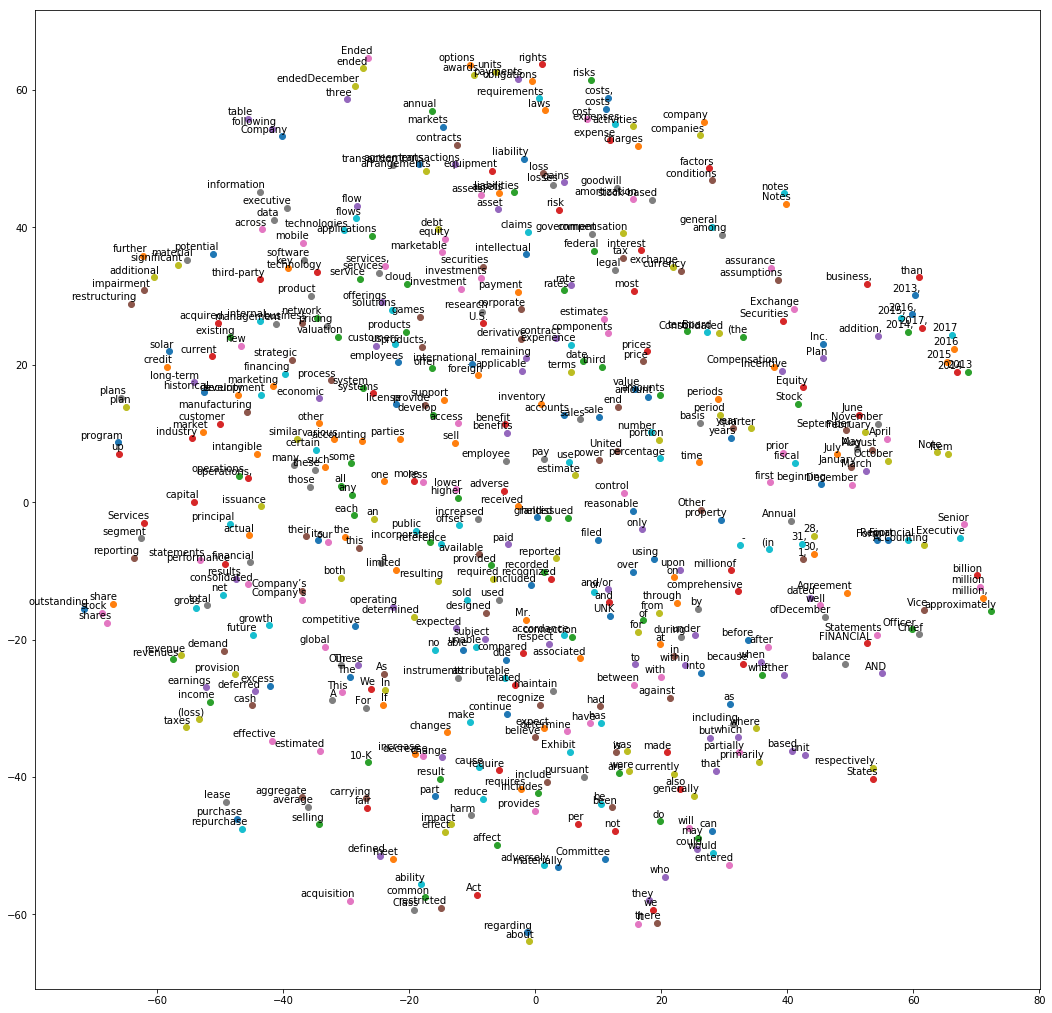

In [179]:
import numpy as np
from six.moves import urllib
from six.moves import xrange  
import tensorflow as tf
import math 
from tensorflow.contrib.tensorboard.plugins import projector
import argparse
import sys
from tempfile import gettempdir


#Store Results in Log 
current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

parser = argparse.ArgumentParser()
parser.add_argument(
    '--log_dir',
    type=str,
    default=os.path.join(current_path, 'log'),
    help='The log directory for TensorBoard summaries.')
FLAGS, unparsed = parser.parse_known_args()


# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.
num_sampled = 64  # Number of negative examples to sample.

valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

graph = tf.Graph()

with graph.as_default():

  # Input data.
  with tf.name_scope('inputs'):
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    with tf.name_scope('embeddings'):
      embeddings = tf.Variable(
          tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    with tf.name_scope('weights'):
      nce_weights = tf.Variable(
          tf.truncated_normal(
              [vocabulary_size, embedding_size],
              stddev=1.0 / math.sqrt(embedding_size)))
    with tf.name_scope('biases'):
      nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  # Explanation of the meaning of NCE loss:
  #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
  with tf.name_scope('loss'):
    loss = tf.reduce_mean(
        tf.nn.nce_loss(
            weights=nce_weights,
            biases=nce_biases,
            labels=train_labels,
            inputs=embed,
            num_sampled=num_sampled,
            num_classes=vocabulary_size))

  # Add the loss value as a scalar to summary.
  tf.summary.scalar('loss', loss)

  # Construct the SGD optimizer using a learning rate of 1.0.
  with tf.name_scope('optimizer'):
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,
                                            valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

  # Merge all summaries.
  merged = tf.summary.merge_all()

  # Add variable initializer.
  init = tf.global_variables_initializer()

  # Create a saver.
  saver = tf.train.Saver()

# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # Open a writer to write summaries.
  writer = tf.summary.FileWriter(FLAGS.log_dir, session.graph)

  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(batch_size, num_skips,
                                                skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # Define metadata variable.
    run_metadata = tf.RunMetadata()

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    # Also, evaluate the merged op to get all summaries from the returned "summary" variable.
    # Feed metadata variable to session for visualizing the graph in TensorBoard.
    _, summary, loss_val = session.run(
        [optimizer, merged, loss],
        feed_dict=feed_dict,
        run_metadata=run_metadata)
    average_loss += loss_val

    # Add returned summaries to writer in each step.
    writer.add_summary(summary, step)
    # Add metadata to visualize the graph for the last run.
    if step == (num_steps - 1):
      writer.add_run_metadata(run_metadata, 'step%d' % step)

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step ', step, ': ', average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = '%s %s,' % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

  # Write corresponding labels for the embeddings.
  with open(FLAGS.log_dir + '/metadata.tsv', 'w') as f:
    for i in xrange(vocabulary_size):
      f.write(reverse_dictionary[i] + '\n')

  # Save the model for checkpoints.
  saver.save(session, os.path.join(FLAGS.log_dir, 'model.ckpt'))

  # Create a configuration for visualizing embeddings with the labels in TensorBoard.
  config = projector.ProjectorConfig()
  embedding_conf = config.embeddings.add()
  embedding_conf.tensor_name = embeddings.name
  embedding_conf.metadata_path = os.path.join(FLAGS.log_dir, 'metadata.tsv')
  projector.visualize_embeddings(writer, config)

writer.close()

# Step 6: Visualize the embeddings.


# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)


try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, 'tsne.png')

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

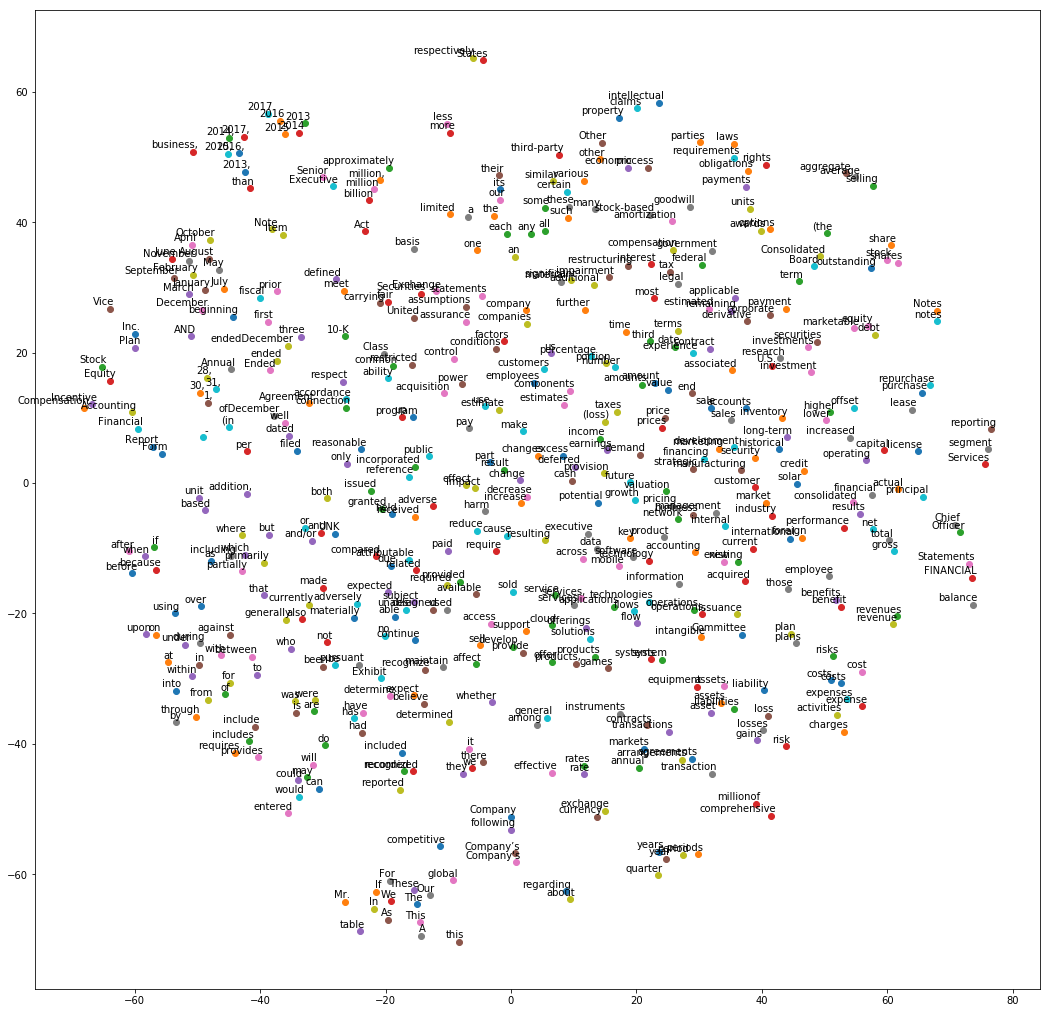

In [184]:
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
  assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')

  plt.savefig(filename)


try:
  # pylint: disable=g-import-not-at-top
  from sklearn.manifold import TSNE
  import matplotlib.pyplot as plt

  tsne = TSNE(
      perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
  plot_only = 500
  low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
  labels = [reverse_dictionary[i] for i in xrange(plot_only)]
  plot_with_labels(low_dim_embs, labels, 'tsne_bis.png')

except ImportError as ex:
  print('Please install sklearn, matplotlib, and scipy to show embeddings.')
  print(ex)

# Associate Each Text Doc with a Specific Return 

In [186]:
#!pip install quandl

In [9]:
info_holder = {}
info_holder['18-01'] = 5

In [24]:
begin = pd.to_datetime('2017-11-03')

In [29]:

begin = begin + timedelta(days=1)


In [34]:
str(begin).split(' ')[0]

'2017-11-04'

In [30]:
begin.dayofweek

5

In [61]:
import pandas as pd 
import quandl 
from datetime import timedelta
quandl.ApiConfig.api_key = 'yybg1hGZXFxDfgdQzcDd' 
def get_return(company, date, delta):
    report_date = pd.to_datetime(date)
    return_date = report_date + timedelta(days=delta)
    if return_date.dayofweek == 5:
        return_date += timedelta(days=2)
    elif return_date.dayofweek == 6:
        return_date += timedelta(days=1)
    data = quandl.get_table('WIKI/PRICES', ticker = [company], 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': date, 'lte': str(return_date).split(' ')[0] }, paginate=True)
    n = data.shape[0]
    if tbl.iloc[0]["adj_close"]  < tbl.iloc[n-1]["adj_close"] :
        return (data, -1)
    else:
        return (data, +1)

    

tbl, Return = get_return('AAPL', '2016-06-05', 3)

In [70]:
info_holder = {}
for company in ['AAPL', 'ACN', 'ADBE']:
    temp = []
    dates = []
    collection = db[company]
    id_list = collection.distinct('_id')
    for id_ in id_list:
        date = collection.find_one({'_id': ObjectId(id_)})['date']
        if date not in dates:
            dates.append(date)
            temp.append({'date':date, 'text':clean_10_K(collection.find_one({'_id': ObjectId(id_)})['10_K']), 
                         'return':0})
    info_holder[company] = temp

In [71]:
info_holder

{'AAPL': [{'date': '2017-11-03',
   'text': ['PagePart',
    'IItem',
    '1.Business1Item',
    '1A.Risk',
    'Factors8Item',
    '1B.Unresolved',
    'Staff',
    'Comments16Item',
    '2.Properties17Item',
    '3.Legal',
    'Proceedings17Item',
    '4.Mine',
    'Safety',
    'Disclosures17Part',
    'IIItem',
    '5.Market',
    'for',
    'Registrant’s',
    'Common',
    'Equity,',
    'Related',
    'Stockholder',
    'Matters',
    'and',
    'Issuer',
    'Purchases',
    'of',
    'Equity',
    'Securities18Item',
    '6.Selected',
    'Financial',
    'Data21Item',
    '7.Management’s',
    'Discussion',
    'and',
    'Analysis',
    'of',
    'Financial',
    'Condition',
    'and',
    'Results',
    'of',
    'Operations22Item',
    '7A.Quantitative',
    'and',
    'Qualitative',
    'Disclosures',
    'About',
    'Market',
    'Risk36Item',
    '8.Financial',
    'Statements',
    'and',
    'Supplementary',
    'Data38Item',
    '9.Changes',
    'in',
    'and',
  

In [180]:
companies_dict.keys()

dict_keys(['AAPL', 'ACN', 'ADBE', 'AMD', 'AKAM', 'ALTR', 'ADI', 'ADSK', 'ADP', 'BRCM', 'CA', 'CSCO', 'CTXS', 'DELL', 'EBAY', 'EA', 'EMC', 'FSLR', 'FCBK', 'GOOG', 'HPQ', 'INTC', 'IBM', 'INTU', 'JNPR', 'MSFT', 'MSI', 'NTAP', 'NVDA', 'ORCL', 'QCOM', 'CRM', 'SNDK', 'STX', 'SYMC', 'TDC', 'TXN', 'VRSN', 'WDN', 'XRX', 'XLNX', 'YHOO', 'AMZN', 'LNKD', 'VZ', 'VMW', 'ZNGA'])

In [17]:
correspd_SEC_quandl = {'AAPL':'AAPL', 'ACN':'ACN','ADBE':'ADBE', 'AMD':'AMD', 'AKAM':'AKAM','ALTR':'ALTR', 'ADI':'ADI', 
                       'ADSK':'ADSK', 'ADP':'ADP', 'BRCM':'BRCM', 'CA':'CA', 'CSCO':'CSCO', 'CTXS':'CTXS', 'DELL':'DELL', 
                       'EBAY':'EBAY', 'EA':'EMC', 'FSLR':'FSLR', 'FCBK':'FB', 'GOOG':'GOOG', 'HPQ':'HPQ', 'INTC':'INTC', 
                       'IBM':'IBM', 'INTU':'INTU', 'JNPR':'JNPR', 'MSFT':'MSFT', 'MSI':'MSI', 'NTAP':'NTAP', 'NVDA':'NVDA', 
                       'ORCL':'ORCL', 'QCOM':'QCOM', 'CRM':'CRM', 'SNDK':'SNDK', 'STX':'STX', 'SYMC':'SYMC', 'TDC':'TDC', 
                       'TXN':'TXN', 'VRSN':'VRSN', 'WDN':'WDC', 'XRX':'XRX', 'XLNX':'XLNX', 'YHOO':'YHOO', 'AMZN':'AMZN', 
                       'LNKD':'LNKD', 'VZ':'VZ', 'VMW':'VMW', 'ZNGA':'ZNGA'}

import quandl
quandl.ApiConfig.api_key = 'yybg1hGZXFxDfgdQzcDd' 
data = quandl.get_table('WIKI/PRICES', ticker = ['AAPL'], 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] }, 
                        date = { 'gte': '2018-01-15', 'lte': '2018-08-15' }, 
                        paginate=True)

In [24]:
data = quandl.get("WIKI/KO", start_date="2018-01-01", end_date="2018-08-15", api_key='yybg1hGZXFxDfgdQzcDd')
data

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-01-02,45.91,45.9400,45.5050,45.54,10721081.0,0.0,1.0,45.91,45.9400,45.5050,45.54,10721081.0
2018-01-03,45.49,45.6900,45.3400,45.44,12287091.0,0.0,1.0,45.49,45.6900,45.3400,45.44,12287091.0
2018-01-04,45.56,46.2150,45.4500,46.08,12665694.0,0.0,1.0,45.56,46.2150,45.4500,46.08,12665694.0
2018-01-05,46.02,46.2000,45.7900,46.07,12244278.0,0.0,1.0,46.02,46.2000,45.7900,46.07,12244278.0
2018-01-08,45.95,46.1000,45.8800,46.00,7031130.0,0.0,1.0,45.95,46.1000,45.8800,46.00,7031130.0
2018-01-09,46.00,46.3600,45.9350,46.23,9933287.0,0.0,1.0,46.00,46.3600,45.9350,46.23,9933287.0
2018-01-10,46.23,46.2600,45.9300,46.07,9841476.0,0.0,1.0,46.23,46.2600,45.9300,46.07,9841476.0
2018-01-11,46.23,46.2300,45.8600,46.04,7581027.0,0.0,1.0,46.23,46.2300,45.8600,46.04,7581027.0
2018-01-12,46.28,46.3900,46.0300,46.15,14544429.0,0.0,1.0,46.28,46.3900,46.0300,46.15,14544429.0


In [31]:
googlefinance("GOOG", "price", "2018-08-01", "2018-08-05", "DAILY")



TypeError: 'module' object is not callable

In [28]:
import googlefinance

In [30]:
from googlefinance import getQuotes

In [37]:
from pandas_datareader import data
import fix_yahoo_finance as yf
yf.pdr_override() 

symbol = 'AMZN'
data_source='google'
start_date = '2010-01-01'
end_date = '2016-01-01'
df = data.get_data_yahoo(symbol, start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded


ValueError: zero-size array to reduction operation maximum which has no identity